In [1]:
# Cell 1: Imports and device setup
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random
import time

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

# For GradCAM
import cv2

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [2]:
# Cell 2: Data transforms and dataset loading

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
}

data_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray"

datasets = {x: ImageFolder(root=f"{data_dir}/{x}", transform=data_transforms[x])
            for x in ['train', 'val', 'test']}

dataloaders = {x: DataLoader(datasets[x], batch_size=32, shuffle=True, num_workers=4)
               for x in ['train', 'val', 'test']}

dataset_sizes = {x: len(datasets[x]) for x in ['train', 'val', 'test']}
class_names = datasets['train'].classes

print("Classes:", class_names)
print("Dataset sizes:", dataset_sizes)


Classes: ['NORMAL', 'PNEUMONIA']
Dataset sizes: {'train': 5216, 'val': 16, 'test': 624}


In [3]:
# Cell 3: Define the model, loss, and optimizer

# Load a pretrained ResNet50 model
model = models.resnet50(pretrained=True)

# Modify the final FC layer for 2 classes
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 197MB/s]


In [4]:
# Cell 4: Evaluation functions

def evaluate_epoch(model, dataloader, criterion):
    """
    Evaluates loss and accuracy on a dataloader.
    Returns: average_loss, average_accuracy.
    """
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
            total_samples += labels.size(0)
    avg_loss = running_loss / total_samples
    avg_acc = running_corrects.double() / total_samples
    return avg_loss, avg_acc.item()

def compute_test_metrics(model, dataloader, criterion):
    """
    Computes additional test metrics: loss, accuracy, precision, recall, F1, AUC, confusion matrix.
    """
    model.eval()
    all_preds = []
    all_labels = []
    running_loss = 0.0
    total_samples = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            total_samples += labels.size(0)
    avg_loss = running_loss / total_samples
    avg_acc = np.sum(np.array(all_preds)==np.array(all_labels)) / total_samples
    
    precision = precision_score(all_labels, all_preds, average='binary')
    recall = recall_score(all_labels, all_preds, average='binary')
    f1 = f1_score(all_labels, all_preds, average='binary')
    try:
        auc = roc_auc_score(all_labels, all_preds)
    except ValueError:
        auc = None
    cm = confusion_matrix(all_labels, all_preds)
    
    return avg_loss, avg_acc, precision, recall, f1, auc, cm

def plot_roc_curve(model, dataloader):
    """
    Plots the ROC curve.
    """
    model.eval()
    all_probs = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            probs = nn.functional.softmax(outputs, dim=1)[:, 1]  # probability for class '1'
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
    auc = roc_auc_score(all_labels, all_probs)
    
    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.4f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.show()


In [5]:
# Cell 5: Training loop

num_epochs = 30  # Adjust as needed
best_test_acc = 0.0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0
    for inputs, labels in dataloaders['train']:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)
        total_samples += labels.size(0)
    
    train_loss = running_loss / total_samples
    train_acc = running_corrects.double() / total_samples
    
    # Evaluate on test set (not validation)
    test_loss, test_acc = evaluate_epoch(model, dataloaders['test'], criterion)
    
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}\n")
    
    # Save best model based on test accuracy
    if test_acc > best_test_acc:
        best_test_acc = test_acc
        torch.save(model.state_dict(), "best_model.pth", _use_new_zipfile_serialization=False)


Epoch 1/30
Train Loss: 0.0984, Train Accuracy: 0.9613
Test Loss: 0.6083, Test Accuracy: 0.7981

Epoch 2/30
Train Loss: 0.0401, Train Accuracy: 0.9864
Test Loss: 0.9337, Test Accuracy: 0.7949

Epoch 3/30
Train Loss: 0.0222, Train Accuracy: 0.9918
Test Loss: 1.0546, Test Accuracy: 0.7532

Epoch 4/30
Train Loss: 0.0192, Train Accuracy: 0.9937
Test Loss: 0.5837, Test Accuracy: 0.8397

Epoch 5/30
Train Loss: 0.0115, Train Accuracy: 0.9967
Test Loss: 0.8647, Test Accuracy: 0.8141

Epoch 6/30
Train Loss: 0.0093, Train Accuracy: 0.9969
Test Loss: 1.7284, Test Accuracy: 0.7404

Epoch 7/30
Train Loss: 0.0202, Train Accuracy: 0.9929
Test Loss: 1.4004, Test Accuracy: 0.7516

Epoch 8/30
Train Loss: 0.0150, Train Accuracy: 0.9946
Test Loss: 1.7284, Test Accuracy: 0.7228

Epoch 9/30
Train Loss: 0.0024, Train Accuracy: 0.9992
Test Loss: 1.2983, Test Accuracy: 0.7821

Epoch 10/30
Train Loss: 0.0044, Train Accuracy: 0.9985
Test Loss: 1.4903, Test Accuracy: 0.7756

Epoch 11/30
Train Loss: 0.0069, Train A

Final Test Metrics:
Loss: 0.5837
Accuracy: 0.8397
Precision: 0.7971
Recall: 0.9974
F1 Score: 0.8861
AUC: 0.7872
Confusion Matrix:
[[135  99]
 [  1 389]]


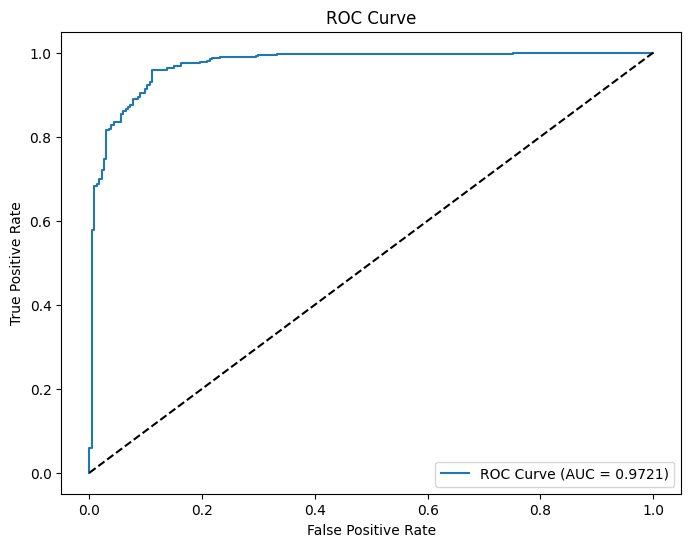

In [6]:
# Cell 6: Load best model and compute final test metrics
model.load_state_dict(torch.load("best_model.pth", weights_only=True))
final_loss, final_acc, precision, recall, f1, auc, cm = compute_test_metrics(model, dataloaders['test'], criterion)

print("Final Test Metrics:")
print(f"Loss: {final_loss:.4f}")
print(f"Accuracy: {final_acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
if auc is not None:
    print(f"AUC: {auc:.4f}")
else:
    print("AUC: Could not be computed.")
print("Confusion Matrix:")
print(cm)

# Plot ROC Curve
plot_roc_curve(model, dataloaders['test'])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


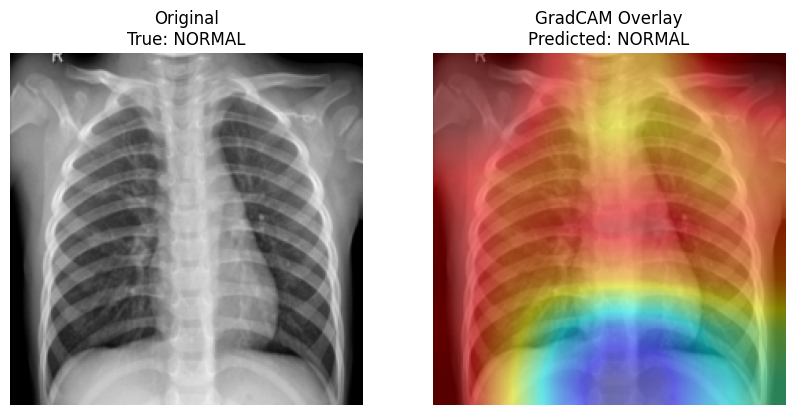

In [7]:
# Cell 7: GradCAM implementation

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_handles = []
        self._register_hooks()
        
    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()
        
        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()
        
        # Register hooks on target layer
        handle_forward = self.target_layer.register_forward_hook(forward_hook)
        handle_backward = self.target_layer.register_backward_hook(backward_hook)
        self.hook_handles.append(handle_forward)
        self.hook_handles.append(handle_backward)
    
    def generate_cam(self, input_tensor, class_idx=None):
        self.model.zero_grad()
        output = self.model(input_tensor)
        
        if class_idx is None:
            class_idx = output.argmax(dim=1).item()
        
        score = output[0, class_idx]
        score.backward()
        
        # Get gradients and activations
        gradients = self.gradients  # shape: [1, C, H, W]
        activations = self.activations  # shape: [1, C, H, W]
        
        # Global average pooling on gradients
        weights = torch.mean(gradients, dim=(2,3), keepdim=True)  # shape: [1, C, 1, 1]
        cam = torch.sum(weights * activations, dim=1)  # shape: [1, H, W]
        
        cam = torch.relu(cam)
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-8)
        cam = cam.cpu().numpy()[0]
        cam = cv2.resize(cam, (224,224))
        return cam

    def remove_hooks(self):
        for handle in self.hook_handles:
            handle.remove()

# Function to show side-by-side original image and GradCAM overlay
def show_gradcam(model, img_tensor, true_label):
    model.eval()
    # Create GradCAM object; target the layer4 of ResNet50
    target_layer = model.layer4  # last conv layer in ResNet50
    grad_cam = GradCAM(model, target_layer)
    
    # Forward pass (unsqueeze to add batch dimension)
    input_tensor = img_tensor.unsqueeze(0).to(device)
    cam = grad_cam.generate_cam(input_tensor)
    
    # Denormalize the image for visualization
    inv_normalize = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )
    img_denorm = inv_normalize(img_tensor).cpu().numpy().transpose((1,2,0))
    img_denorm = np.clip(img_denorm, 0, 1)
    
    # Overlay the CAM on the image
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    overlay = heatmap + np.float32(img_denorm)
    overlay = overlay / np.max(overlay)
    
    # Get model prediction for the image
    output = model(input_tensor)
    _, pred = torch.max(output, 1)
    pred_label = class_names[pred.item()]
    true_label_str = class_names[true_label]
    
    # Plot side-by-side
    fig, axs = plt.subplots(1,2, figsize=(10,5))
    axs[0].imshow(img_denorm)
    axs[0].set_title(f"Original\nTrue: {true_label_str}")
    axs[0].axis('off')
    axs[1].imshow(overlay)
    axs[1].set_title(f"GradCAM Overlay\nPredicted: {pred_label}")
    axs[1].axis('off')
    plt.show()
    grad_cam.remove_hooks()

# Example: Pick a random image from the test set and show GradCAM visualization
inputs, labels = next(iter(dataloaders['test']))
idx = random.randint(0, inputs.size(0)-1)
show_gradcam(model, inputs[idx], labels[idx].item())
